In [1]:
from NetClasses import *
from SobolevClasses import *
import pandas as pd

2024-06-16 21:38:40.763704: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

Attempt to use neural networks to approximate functions in the Discrete Sobolev Space

## What we want to show

$$
\left\| f - \sum_{j=1}^{n} a_j(f) \varphi(A_j(\cdot) + b)  \right\|_p \leq c n^{-r/s} \left\| f \right\|_{W_{r,s}^{p}}
$$

i.e. the neural network can approximate the function in the Sobolev space with a rate of $n^{-r/s}$ w.r.t the Lp norm.

### Notation
- $r$ : smoothness of the function in the Sobolev space
- $p$ : $L^p$ norm to be used
- $s$ : dimension of the input space

In [2]:
def RunShallowTest(f,n_inputs=1,n_outputs=1,n_samples=200):
    """
    Input: f a function
    Output: Graph of final loss of varying width shallow networks
    """

    # Create Dataset Generator
    gen_func = FunctionSamples(f, n_samples=n_samples, n_inputs=n_inputs, n_outputs=n_outputs)
    ds = gen_func.get_dataset()

    def Lp_loss(y_true, y_pred, p=2):
        if p < 1:
            raise ValueError("p must be greater than or equal to 1")

        # Calculate the absolute difference raised to the power of p
        difference_power_p = abs(y_true - y_pred) ** p

        # Take the p-th root of the result
        return difference_power_p ** (1/p)

    # Take 20 Widths from 1->2500
    N = np.arange(1, 2500, 125)
    # Create empty dataframe to store results
    results = pd.DataFrame(columns=['N', 'Loss'])
    # Number of trials ran
    for i in range(20):
        # Create the network
        # Structure: number of neurons
        # Input Layer: n_inputs
        # Hidden layer: n
        # Output layer: n_outputs

        for n in tqdm(N, desc=f"Trial {i}"):
          with tf.device('/device:GPU:0'):
            net = ShallowNetwork(n_inputs,n,n_outputs).build_model()
            ds = gen_func.get_dataset()

            net.compile(optimizer='adam', loss=Lp_loss)
            net.fit(ds, epochs=50, verbose=0)
            loss = net.evaluate(ds, verbose=0)
            results = pd.concat([results, pd.DataFrame({'N': [n], 'Loss': [loss]})])
            # print(f"n: {n}, loss: {loss}")

    results.to_csv(f"data/Shallow{f.__name__}.csv")
    # Average the results
    results = results.groupby('N').mean()
    results.plot()
    plt.title(f"Sobolev Test for {f.__name__}")
    plt.xlabel("Width of Network")
    plt.ylabel("Loss")
    plt.yscale('log')
    plt.show()
    return results

Trial 0:   0%|          | 0/20 [00:00<?, ?it/s]

/Users/arnav/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-16 21:43:14.818305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/arnav/opt/anaconda3/envs/tf/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-06-16 21:43:15.031168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with sta

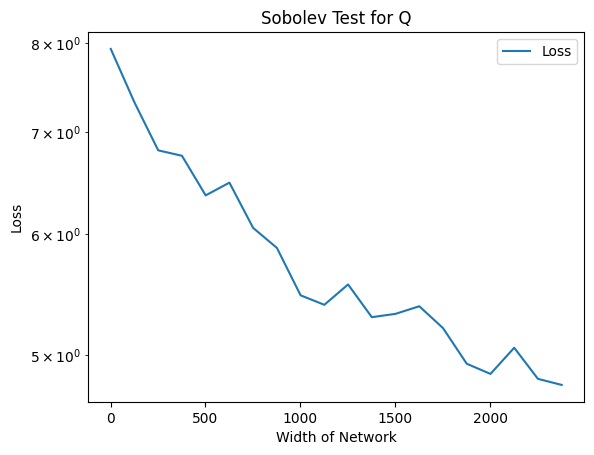

Loss
N             
1     7.929823
126   7.316129
251   6.807604
376   6.752181
501   6.361692
626   6.484436
751   6.057554
876   5.878363
1001  5.473325
1126  5.395994
1251  5.563697
1376  5.296392
1501  5.323028
1626  5.384116
1751  5.210060
1876  4.938038
2001  4.863106
2126  5.058331
2251  4.826977
2376  4.783137

In [5]:
def h(a,b,c,d):
    return np.sqrt(
        4*np.power((2*a + 3*b),4) + 5*np.power((2*c + 3*d),4)
    )

RunShallowTest(Q, n_inputs=4,n_outputs=1,n_samples=100)